<span style="color:#4287f5; font-size:1.2em; font-weight:bold;">1- Import des bibliothèques :</span>

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import warnings

# Supprimer les warnings pour une meilleure lisibilité
warnings.filterwarnings("ignore")

# Pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

<span style=" color:#4287f5; font-size:1.2em; font-weight:bold"> 2-chargement des données précedemment traités dans l'exploration et indexation de variable temporelle </span>

In [2]:
print(" 1.Chargement des données traitées...")
 
# Utilisation du chemin fourni pour le fichier df_processed.csv
processed_file_path = r"../../data/df_jointure_inner.csv"
if not os.path.exists(processed_file_path):
    raise FileNotFoundError(f"Le fichier {processed_file_path} n'existe pas. Veuillez vérifier le chemin.")
df = pd.read_csv(processed_file_path, parse_dates=['date_heure'], index_col='date_heure')
# Vérification des données
print("Données chargées avec succès. Voici les premières lignes :")
print(df.head())
# --- 2. Analyse exploratoire des données ---
# Vérification des types de données
print("\nTypes de données dans le DataFrame :")

print(df.dtypes)
# Vérification des valeurs manquantes
print("\nValeurs manquantes dans le DataFrame :")
print(df.isnull().sum())
# Vérification des doublons
print("\nNombre de doublons dans le DataFrame :")
print(df.duplicated().sum())

 1.Chargement des données traitées...


ValueError: Missing column provided to 'parse_dates': 'date_heure'

<span style=" color:#4287f5 ; font-size:1.2em; font-weight:bold" > 3 - Agrégation quotidienne</span>

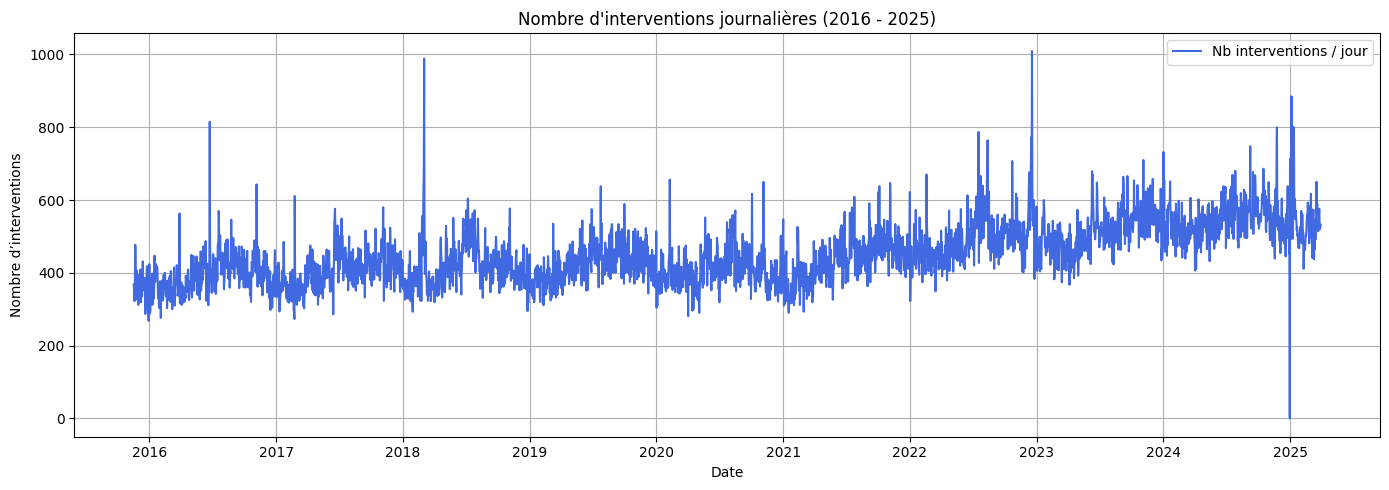

In [4]:
# --- 2. Création de la série temporelle quotidienne ---
series_journalière = df.resample('D').size()  # Compte le nombre d’interventions par jour

# Visualisation
plt.figure(figsize=(14, 5))
plt.plot(series_journalière, label='Nb interventions / jour', color='royalblue')
plt.title("Nombre d'interventions journalières (2016 - 2025)")
plt.xlabel("Date")
plt.ylabel("Nombre d’interventions")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 <span style=" color:#4287f5 ; font-size:1.2em; font-weight:bold" > 4 - Décomposition de la série temporelle </span>

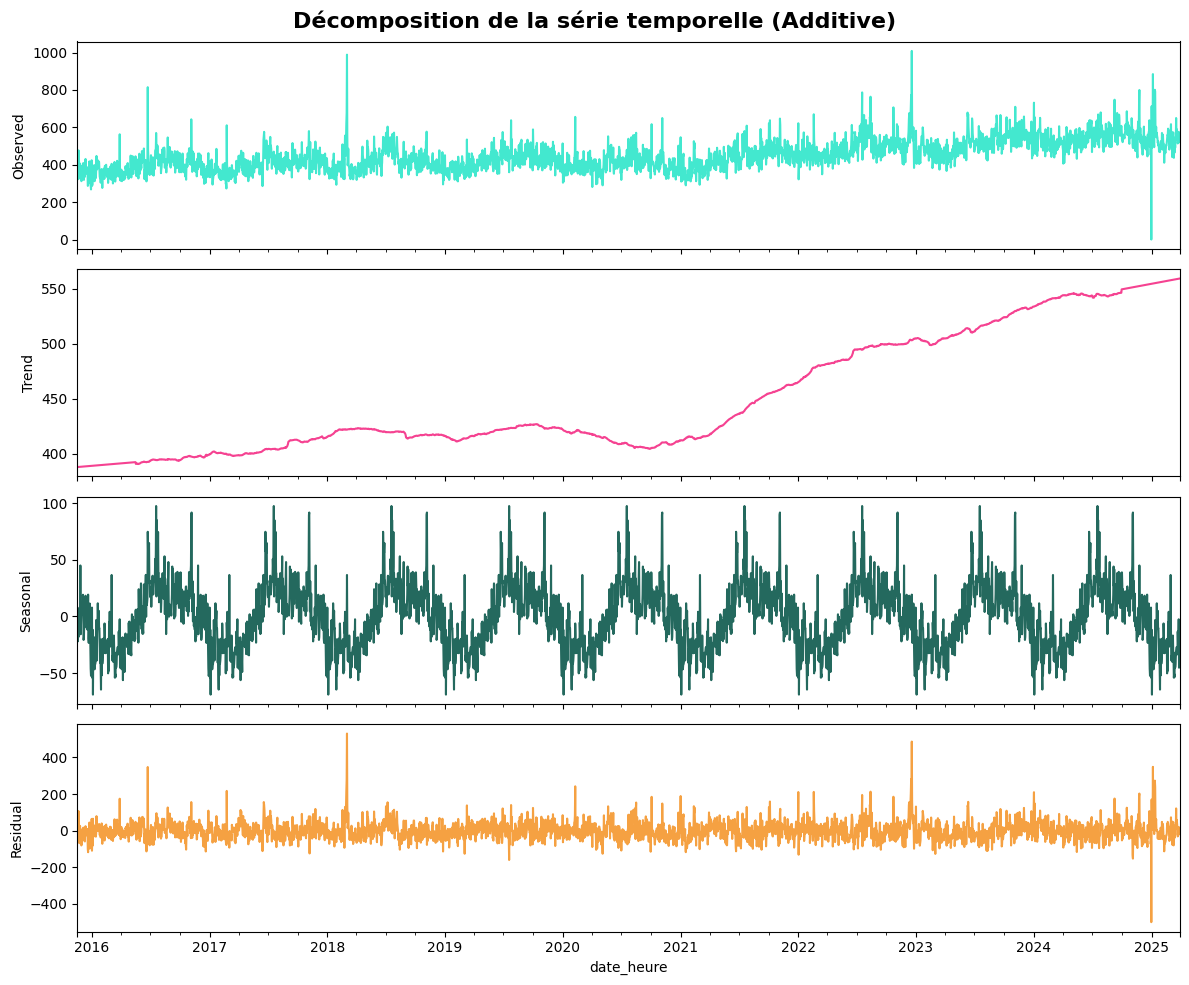

In [5]:
# Décomposition saisonnière 
decomposition = seasonal_decompose(series_journalière, model='additive', period=365, extrapolate_trend='freq', two_sided=True)

# Création de la figure
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Couleurs personnalisées pour chaque composante
couleurs = {'observed':'#43e8cf', 'trend':'#f54291', 'seasonal':'#24695e', 'resid': '#f5a142' }

# Tracés avec couleurs spécifiques
decomposition.observed.plot(ax=axes[0], color=couleurs['observed'])
axes[0].set_ylabel('Observed')

decomposition.trend.plot(ax=axes[1], color=couleurs['trend'])
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], color=couleurs['seasonal'])
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], color=couleurs['resid'])
axes[3].set_ylabel('Residual')

# Titre principal et ajustement
plt.suptitle("Décomposition de la série temporelle (Additive)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

1. Série originale
Fluctuations journalières marquées avec des pics ponctuels.
2. Tendance
Hausse progressive du nombre d’incidents entre 2016 et début 2025. ==> Croissante
Non stationnaire

3. Saisonnalité
Amplitude stable , saisonnalité annuelle visible ⇒ cohérence avec un modèle additif.
Modélisation : un SARIMA annuel

4. Résidus
Majoritairement aléatoires, centrés autour de zéro (bruit blanc).
Quelques outliers détectés (événements exceptionnels comme vu precedemment !).

==> La décomposition valide la présence :
d’une tendance ascendante,
d’une saisonnalité stable.
Elle confirme la pertinence du modèle SARIMA, qui permet de prendre en compte ces deux composantes pour améliorer la précision des prévisions.



<span style=" color:#4287f5 ; font-size:1.2em; font-weight:bold" > 5 - Test de stationnarité (ADF Test) </span>

ADF Statistic : -3.1522710770250226
p-value : 0.022919045954070724
La série est stationnaire (p <= 0.05)


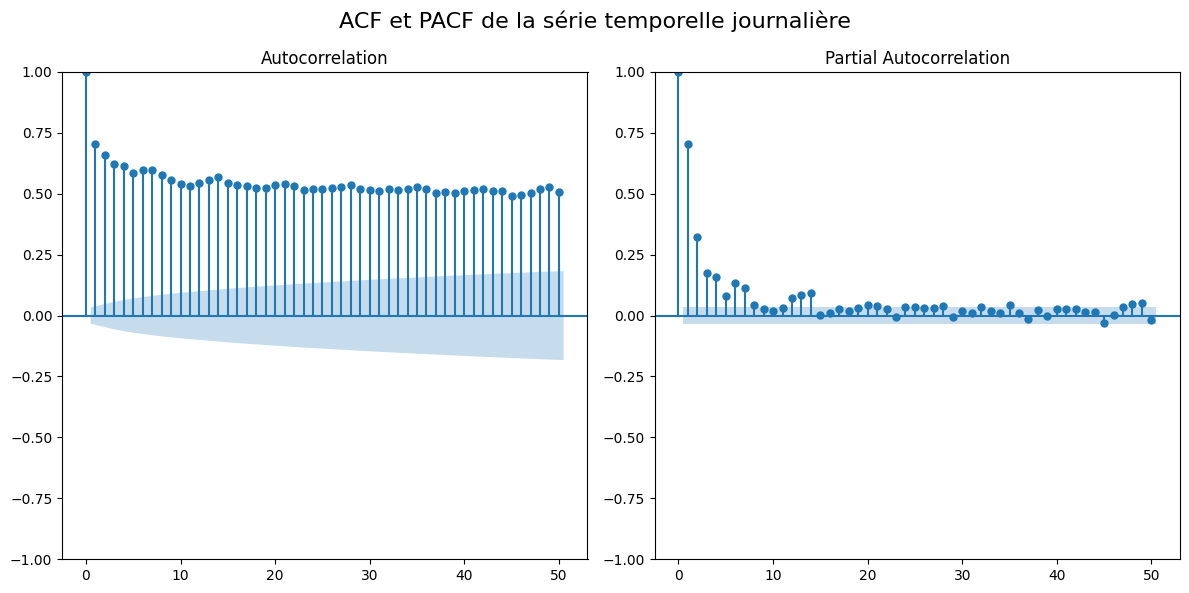

In [6]:
# Test ADF (Augmented Dickey-Fuller)
result = adfuller(series_journalière.dropna())
print('ADF Statistic :', result[0])
print('p-value :', result[1])
if result[1] <= 0.05:
    print("La série est stationnaire (p <= 0.05)")
else:
    print("La série n’est pas stationnaire (p > 0.05) — Il faudra différencier ! ")
# Visualisation des ACF et PACF ---
plt.figure(figsize=(12, 6))
plot_acf(series_journalière.dropna(), lags=50, ax=plt.subplot(121))
plot_pacf(series_journalière.dropna(), lags=50, ax=plt.subplot(122))
plt.suptitle("ACF et PACF de la série temporelle journalière", fontsize=16)
plt.tight_layout()
plt.show()

À partir des graphes :

ACF  à gauche : décroissance lente → présence de dépendance persistante = composante AR saisonnière.

PACF à droite : décroissance rapide après le lag 2 à 3, donc composante AR(p) = 2 ou 3 max.

Hypothèse initiale du modèle SARIMA
En prenant en compte :

Une saisonnalité annuelle → s = 365
 Le test ADF a donné une p-value de 0.0229, ce qui vous a conduit à conclure que "La série est stationnaire (p <= 0.05)". Une série stationnaire ne nécessite pas de différenciation, ce qui implique d=0.

<span style=" color:#4287f5 ; font-size:1.2em; font-weight:bold" > 6 – Modélisation SARIMA et prédictions </span>

In [ ]:
# Re-sampling, imputation des valeurs manquantes
y = df.resample('D').size().asfreq('D').fillna(0)

# Entraînement SARIMA
print("Entraînement du modèle SARIMA(2,1,2)(1,1,1,365)...")
model = SARIMAX(y, order=(2, 1, 2), seasonal_order=(1, 1, 1, 365), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print("Modèle entraîné.\n")
print(results.summary())


Entraînement du modèle SARIMA(2,1,2)(1,1,1,365)...
